##### Student information:
- Name: Tuan Anh NGUYEN
- Email: tuan.nguyen@etu.univ-cotedazur.fr

---

## Project Description

### 1. Objective
The aim of this project is to propose both a Machine Learning (ML) model and a Deep Learning (DL) model capable of filling in the attendance sheet after taking a photo of the classroom.

### 2. Allowed Resources
Everything covered in the ML and DL courses can be used.

### 3. Dataset Preparation
- Detail the process of building training datasets to recognize people.
- For the ML approach, pre-processing of the image (e.g., segmentation) can leverage Deep Learning methods.

### 4. Steps
1. **Face Detection:** Identify faces in the image and determine the number of people in the room (segmentation problem).
2. **Gender Recognition:** Classify the gender of each detected face. (For this project, I think it does not need 'Gender Recognition')
3. **Identity Recognition:** Identify each person in the image (describe the exact method and constraints).

### 5. Additional Notes
- External datasets can be used for training or fine-tuning parts of the project.
- The project deliverables include:
  - A Jupyter Notebook implementing the proposed solution.
  - A scientific article (5 to 10 pages) presenting the methodology, strengths, and limitations, with references.
  - Ethical considerations can be referenced based on the ethics lecture.
---



### Stractegic Plan of Action for Deep Learning Approach:

1. *Data Prepairing*

2. *Model Building*

3. *Result*

4. *Task Outcomes & Conclusion*

## Imports

In [ ]:
!pip install torchinfo
!pip install ultralytics

In [56]:
import torch
from torchvision.models import resnet34, ResNet34_Weights
import torchvision.transforms as transforms
from torch import nn
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import random
import cv2

from ultralytics import YOLO


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Class.zip" -d "/content"

Archive:  /content/drive/MyDrive/Class.zip
   creating: /content/Class/
   creating: /content/Class/Abinav/
  inflating: /content/Class/Abinav/face_100_12.jpg  
  inflating: /content/Class/Abinav/face_102_12.jpg  
  inflating: /content/Class/Abinav/face_103_12.jpg  
  inflating: /content/Class/Abinav/face_104_13.jpg  
  inflating: /content/Class/Abinav/face_105_9.jpg  
  inflating: /content/Class/Abinav/face_106_8.jpg  
  inflating: /content/Class/Abinav/face_107_8.jpg  
  inflating: /content/Class/Abinav/face_108_10.jpg  
  inflating: /content/Class/Abinav/face_109_12.jpg  
  inflating: /content/Class/Abinav/face_111_11.jpg  
  inflating: /content/Class/Abinav/face_112_11.jpg  
  inflating: /content/Class/Abinav/face_114_11.jpg  
  inflating: /content/Class/Abinav/face_115_17.jpg  
  inflating: /content/Class/Abinav/face_116_16.jpg  
  inflating: /content/Class/Abinav/face_117_13.jpg  
  inflating: /content/Class/Abinav/face_118_14.jpg  
  inflating: /content/Class/Abinav/face_119_11.

 ---
### <center> 1. Data Prepairing
 ---

#### 1.1. Build dataset

- Load images from the dataset. I had built this dataset based on the video and images of classmates with their permission.

In [50]:
input_folder = '/content/Class'

# Get the faces images
count = 0
faces_data_dict = {}
person_label_dict = {}
for person_folder in os.listdir(input_folder):
    person_folder_path = os.path.join(input_folder, person_folder)
    person_label_dict[count] = person_folder
    lst_faces_img = []
    for filename in os.listdir(person_folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(person_folder_path, filename)
            lst_faces_img.append(img_path)

    faces_data_dict[count] = lst_faces_img
    count +=1

print(person_label_dict)

{0: 'Zeev', 1: 'Hasham', 2: 'Tuan Anh', 3: 'Nestor', 4: 'Usman', 5: 'Gerard', 6: 'Ubaid', 7: 'Eli', 8: 'Melissa', 9: 'Juliana', 10: 'Hassan', 11: 'Abinav', 12: 'Dialo', 13: 'Tuan', 14: 'Ismail', 15: 'Arion', 16: 'Nabila', 17: 'Hadi', 18: 'Youssef', 19: 'Zahid'}


- Create a dictionary to map the path of image files with coressponding labels

In [52]:
images_labels_dict = {img:k for k,v in faces_data_dict.items() for img in v}
images = list(images_labels_dict.keys())
random.shuffle(images)
faces_dataset = [(x, images_labels_dict[x]) for x in images]
print(len(faces_dataset))
print(faces_dataset[0])

4006
('/content/Class/Gerard/face_267_8.jpg', 5)


- Build the preprocessing pipeline for images. Because our core model is ResNet34, so I will use preprocessing of ResNet34.

In [ ]:
resnet_weights = ResNet34_Weights.DEFAULT
resnet_transform = resnet_weights.transforms()
print(resnet_transform)
preproccesing_pipeline = transforms.Compose([
                resnet_transform,
                transforms.Grayscale(num_output_channels=3)
            ])

- Function to load the data. Here, I moved the axis from (H,W,C) to (C,H,W) to fit the preprocessing pipeline

In [ ]:
def load_data(dataset):
    X = []
    y = []
    for image_path, label in dataset:
        img = cv2.imread(image_path)
        img_tensor = torch.tensor(img).moveaxis((0,1,2),(1,2,0))  # Move axis from (H,W,C) to (C,H,W)
        # print(img_tensor.shape)
        X.append(preproccesing_pipeline(img_tensor))
        y.append(label)

    return np.array(X), np.array(y)

X, y = load_data(faces_dataset)

#### 1.2. Prepare the data for training steps

- Separate the dataset into train and validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

- Create the DataLoader to prepare for training steps

In [16]:
# Transform to tensor
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

 ---
### <center> 2. Predictive Modeling
 ---

#### 2.1. Building the model

- Build the Module to compute the Additive Angular Margin Loss (AAM loss)

In [17]:
class AdditiveAngularMarginLoss(nn.Module):
    def __init__(self, s=64.0, margin=0.5):
        super().__init__()
        self.s = s
        self.margin = margin

    def forward(self, logits, labels):
        # Get non-ignored index
        idx = torch.nonzero(labels != -1).squeeze()
        # y_i in the formula of L_AAM
        y_i = logits[idx, labels[idx].view(-1)]

        with torch.no_grad():
            # theta y_i
            y_i.arccos_()
            # theta j (including target y_i)
            logits.arccos_()
            # theta y_i + m term
            final_target_logit = y_i + self.margin
            # insert the above result to the right term of the denominator
            # for calculation convenience
            logits[idx, labels[idx].view(-1)] = final_target_logit
            # calculation cosine function
            logits.cos_()

        logits = logits * self.s
        return logits


- Build the model Attendance Recognization. In this project, I will try to train the whole model.

In [18]:
class AttendanceRecognization(nn.Module):
  def __init__(self, num_classes) -> None:
    super().__init__()

    # Load pre-trained ResNet-34
    self.resnet_model = resnet34(weights=resnet_weights)
    # Unfreeze all parameters in the model
    for param in self.resnet_model.parameters():
      param.requires_grad = True
    # AAM Loss
    self.angular_margin_penalty = AdditiveAngularMarginLoss(margin = 0.7)
    # Fully connector fc2 (1000 -> num_classes)
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(1000, num_classes)
  def forward(self, x, label=None):
    # ResNet part
    x = self.relu(self.resnet_model(x))
    x = self.fc2(x)
    x = torch.nn.functional.normalize(x, p=2, dim=1)

    # AAM part:
    if label is not None:
      logits = self.angular_margin_penalty(x, label)
    else:
      logits = x

    return logits


#### 2.2. Training part


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- Build EarlyStopping to prevent overfitting

In [28]:
# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

- Create the AttendanceRecognization model. Print the summary of the whole model.

In [29]:
recognition_model = AttendanceRecognization(num_classes=len(np.unique(y))).to(device)
summary(recognition_model, (32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
AttendanceRecognization                       [32, 20]                  --
├─ResNet: 1-1                                 [32, 1000]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-3                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         230,144

- Training steps

In [30]:
epochs = 100
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(recognition_model.parameters(), lr= 0.001)

best_vloss = 1e6
best_epoch = 0  # Saving the best epoch of the model to use
early_stopping = EarlyStopping(patience=5)

train_loss_total = []
val_loss_total = []
train_acc_total = []
val_acc_total = []

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch + 1))
    # Training part
    recognition_model.train()
    training_losses = []
    train_accs = 0.0
    for batch, (X_, y_) in enumerate(train_dataloader):
        train_pred = recognition_model(X_.to(device), y_.to(device))
        tloss = loss_function(train_pred, y_.to(device))
        training_losses.append(tloss.item())
        optimizer.zero_grad()
        tloss.backward()
        optimizer.step()

        pred = train_pred.argmax(dim=1, keepdim=True)           # Get the prediction label
        acc = pred.eq(y_.to(device).view_as(pred)).sum().item() # Compute the accuracry
        train_accs += acc

    training_loss = np.mean(training_losses)    # Take the average loss
    train_loss_total.append(training_loss)
    train_acc = train_accs / len(train_dataset) # Take the average accuracy
    train_acc_total.append(train_acc)

    # Validation part
    recognition_model.eval()
    validation_losses = []
    val_accs = 0.0
    with torch.inference_mode():
        for batch, (X_, y_) in enumerate(val_dataloader):
            val_pred = recognition_model(X_.to(device), y_.to(device))
            vloss = loss_function(val_pred, y_.to(device))
            validation_losses.append(vloss.item())

            pred = val_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y_.to(device).view_as(pred)).sum().item()
            val_accs += acc

    validation_loss = np.mean(validation_losses)
    val_loss_total.append(validation_loss)
    val_acc = val_accs / len(val_dataset)
    val_acc_total.append(val_acc)

    print('LOSS train {} valid {} -- ACC train {} valid {}'.format(training_loss, validation_loss, train_acc, val_acc))

    # Early stopping check:
    early_stopping(validation_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    # Track best performance, and save the model's state
    if validation_loss < best_vloss:
        best_vloss = validation_loss
        best_epoch = epoch
        model_path = 'model_root_{}'.format(epoch)
        torch.save(recognition_model.state_dict(), model_path)



EPOCH 1:
LOSS train 40.17006281106779 valid 40.46531383807842 -- ACC train 0.10955056179775281 valid 0.14962593516209477
EPOCH 2:
LOSS train 30.472745045576946 valid 27.52257622205294 -- ACC train 0.2690387016229713 valid 0.40399002493765584
EPOCH 3:
LOSS train 22.281327908582025 valid 52.29421630272498 -- ACC train 0.43976279650436956 valid 0.18079800498753118
EPOCH 4:
LOSS train 15.608219954046872 valid 13.38723923609807 -- ACC train 0.5789637952559301 valid 0.6446384039900249
EPOCH 5:
LOSS train 9.309211424081633 valid 13.111509868731861 -- ACC train 0.7506242197253433 valid 0.7094763092269327
EPOCH 6:
LOSS train 7.856510747777353 valid 9.027152769840033 -- ACC train 0.7702871410736579 valid 0.7780548628428927
EPOCH 7:
LOSS train 7.052691634928826 valid 10.07061133476404 -- ACC train 0.8089887640449438 valid 0.78428927680798
EPOCH 8:
LOSS train 5.3096423198857705 valid 10.08369572914783 -- ACC train 0.8520599250936329 valid 0.7755610972568578
EPOCH 9:
LOSS train 4.077485484218612 va

- Babysitting the model

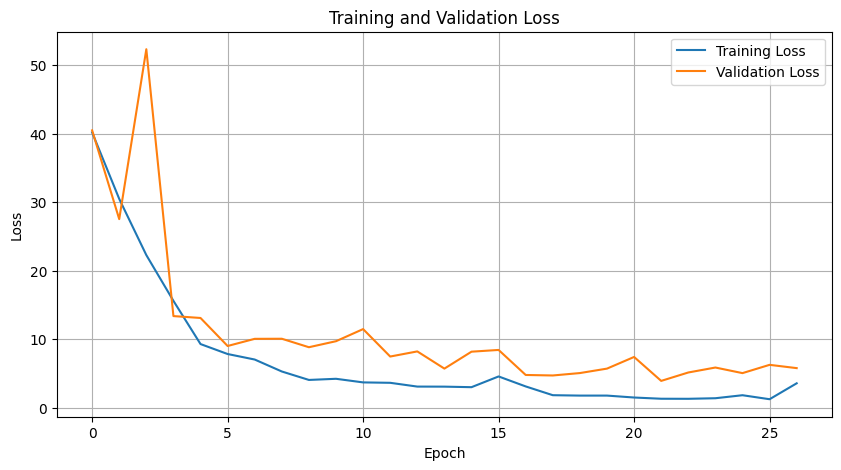

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_total, label='Training Loss')
plt.plot(val_loss_total, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


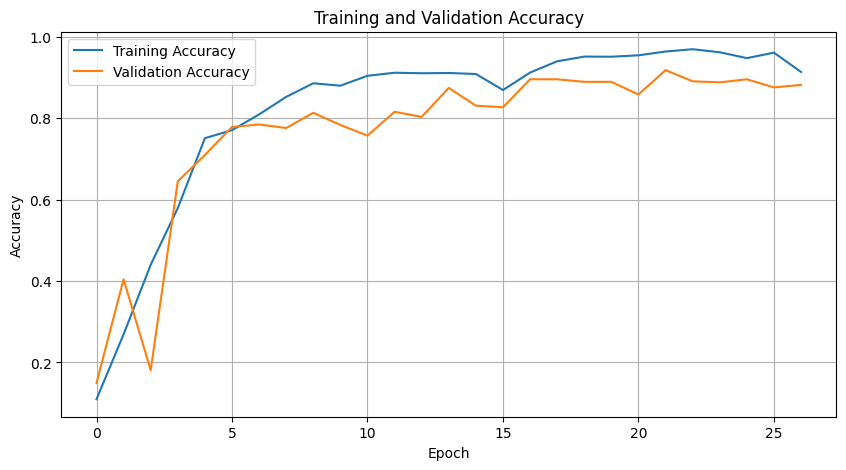

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_total, label='Training Accuracy')
plt.plot(val_acc_total, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

 ---
### <center> 3. Result
 ---

- Load the best model

In [53]:
print("Best epoch: ", best_epoch)
recognition_model.load_state_dict(torch.load('model_root_{}'.format(best_epoch), weights_only=True))

Best epoch:  21


<All keys matched successfully>

- Build the function to capture the faces from the test image.

In [ ]:

def crop_faces(image_path, save_path=None, visualize=False):

    # Load the YOLOv8-face model
    face_detection_model = YOLO("/content/drive/MyDrive/yolov8n-face.pt")

    # Load an image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Transform to RGB


    # Run inference
    results = face_detection_model.predict(img, conf=0.5)

    cropped_faces = []

    # Extract bounding boxes
    for result in results:
        boxes = result.boxes  # Bounding box outputs

        # Loop over detected faces
        for box in boxes:
            # Get coordinates (in pixel values)
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Crop faces
            face_crop = img_rgb[y1:y2, x1:x2]
            cropped_faces.append(face_crop)

            # Get confidence score
            confidence = box.conf[0].item()

            # Draw the bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add confidence text
            label = f"Face: {confidence:.2f}"
            cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if visualize:
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

    return cropped_faces

- Build the function to make the prediction


In [62]:
def predict_faces(faces):
  face_tensor = torch.stack([preproccesing_pipeline(torch.tensor(face).moveaxis((0,1,2),(1,2,0))) for face in faces]) # Preprocessing the extracted faces
  y_pred = recognition_model(face_tensor.to(device))  # get the predictions
  pred_face = y_pred.argmax(dim = 1)

  # Print faces with labels
  for f, label in zip(faces,pred_face):
    plt.imshow(f)
    plt.axis('off')
    print(person_label_dict[int(label.cpu())])
    plt.show()

  return pred_face

- Finally, fill the attendance sheet with the input images.


0: 448x640 13 faces, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


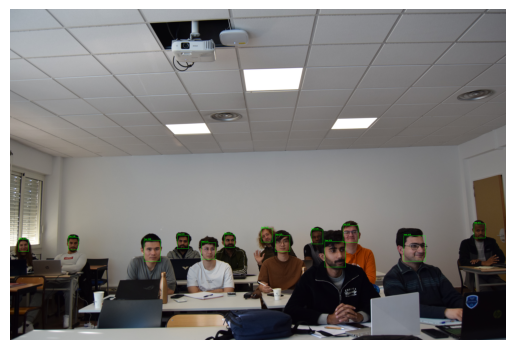

Tuan Anh


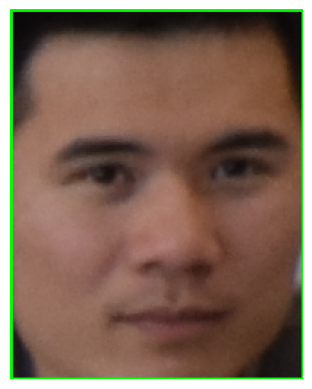

Arion


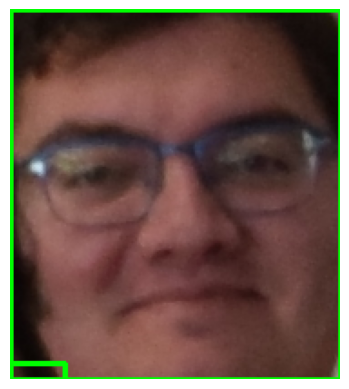

Tuan


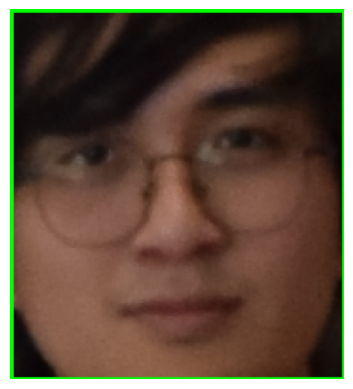

Hasham


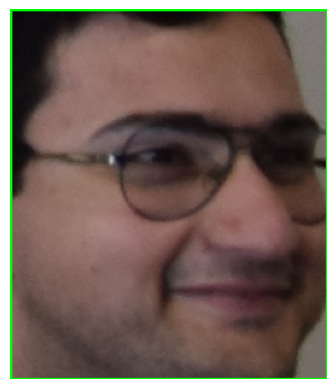

Usman


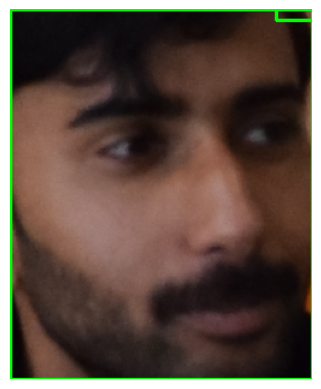

Nabila


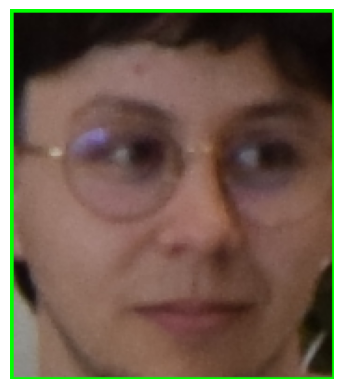

Ismail


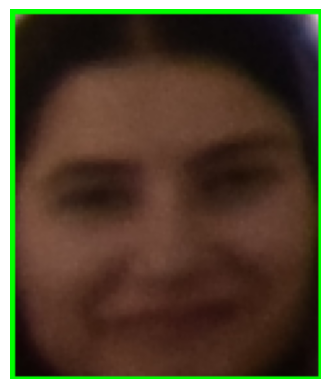

Dialo


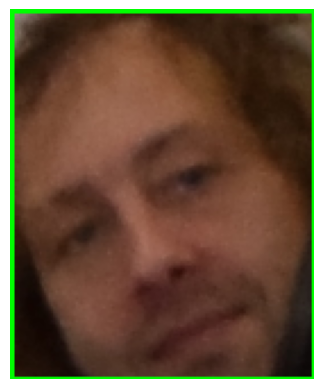

Abinav


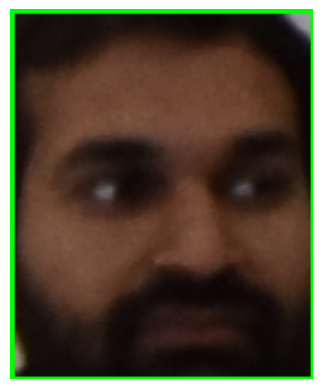

Gerard


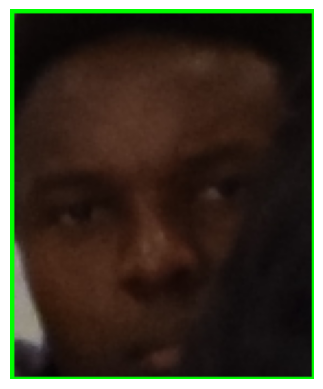

Ubaid


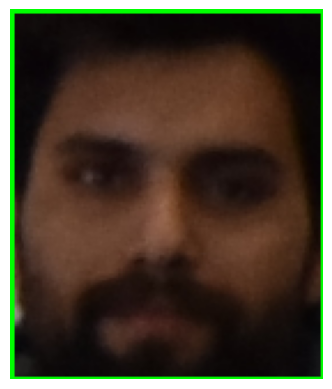

Dialo


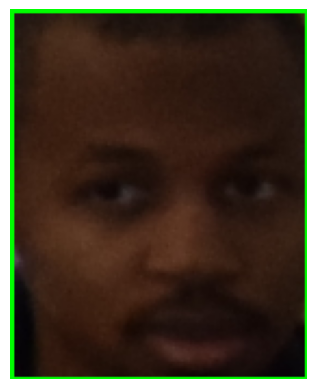

Youssef


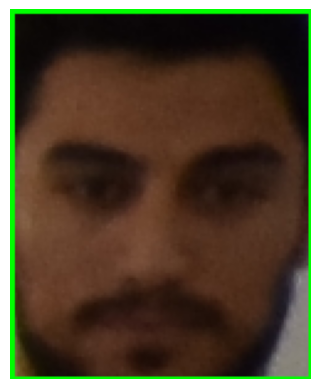

        Name  Attendance
0       Zeev         0.0
1     Hasham         1.0
2   Tuan Anh         1.0
3     Nestor         0.0
4      Usman         1.0
5     Gerard         1.0
6      Ubaid         1.0
7        Eli         0.0
8    Melissa         0.0
9    Juliana         0.0
10    Hassan         0.0
11    Abinav         1.0
12     Dialo         1.0
13      Tuan         1.0
14    Ismail         1.0
15     Arion         1.0
16    Nabila         1.0
17      Hadi         0.0
18   Youssef         1.0
19     Zahid         0.0


In [68]:
def attendance_sheet(img_path):
  faces = crop_faces(image_path = img_path, visualize=True)
  p_faces = predict_faces(faces)

  attendances = np.zeros(shape=(len(person_label_dict.keys())))
  attendances[p_faces.cpu().numpy()] = 1
  df = pd.DataFrame({'Name': list(person_label_dict.values()), 'Attendance': attendances})
  print(df)

attendance_sheet("/content/drive/MyDrive/project_test_images/2.JPG")

- From that result, we can see that the correct prediction rate is: 10/13. We have 3 wrong predictions are Melissa -> Ismail, Nestor -> Nabila, Zeev -> Dialo.

 ---
### <center> 4. Task outcomes and Conclusion
 ---

- The model has the huge number of parameters, it consumes the huge amount of time to train.
- The quality of the dataset is pretty good, the rate 10/13 is not too bad.
- Wrong predictions can come from various reasons, one of them is the dataset too small and I don't have external dataset to train the model.

 ---
### <center> 5. (Additional) Data extraction from the video and images
 ---

- Input folder which is the images include many people. The output folder is the folder where new images located.

In [ ]:
input_folder = r'C:\Users\Admin\Master Program\Projects\Project_2\img\Labeled Photos Folder-20250221T143351Z-001'
output_folder = r'C:\Users\Admin\Master Program\Projects\Project_2\img\extracted_new_faces'

- Extracting faces from images

In [ ]:
# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
count = 0
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(input_folder, filename)
        # print(img_path)
        # Load the YOLOv8-face model
        face_detection_model = YOLO("yolov8n-face.pt")
        try:
            # Run inference
            results = face_detection_model.predict(img_path, conf=0.5)

            cropped_faces = []

            # Extract bounding boxes
            for result in results:
                boxes = result.boxes  # Bounding box outputs

                # Loop over detected faces
                for idx, box in enumerate(boxes):
                    # Get coordinates (in pixel values)
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    # Crop faces
                    face_crop = img_rgb[y1:y2, x1:x2]
                    out_path = os.path.join(output_folder, f"face_{count}_{idx}.jpg")

                    # Save the extracted faces
                    img_rgb = cv2.cvtColor((face_crop * 255).astype("uint8"), cv2.COLOR_BGR2RGB)  # Transform to RGB

                    cv2.imwrite(out_path, img_rgb)
            count +=1


        except Exception as e:
            print(e)

- Data augmentation

In [ ]:
# resnet_weights = ResNet34_Weights.DEFAULT

# resnet_transform = resnet_weights.transforms()

augmentation_pipeline = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                transforms.RandomAutocontrast(p=0.5),
                transforms.RandomResizedCrop(size=(255, 255), scale=(1, 1.5), ratio=(0.5,0.8)),
            ])

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
count = 195
for person_folder in os.listdir(input_folder):
    person_folder_path = os.path.join(input_folder, person_folder)
    output_path = os.path.join(output_folder, person_folder)
    for _ in range(1):
        for filename in os.listdir(person_folder_path):
            if filename.lower().endswith((".jpg", ".jpeg", ".png",".jfif")):
                img_path = os.path.join(person_folder_path, filename)
                # print(img_path)
                img = cv2.imread(img_path)
                try:
                    aug_face = augmentation_pipeline(torch.tensor(img).moveaxis((0,1,2),(1,2,0)))
                    out_path = os.path.join(output_path, f"face_aug_{count}.jpg")
                    # # Save the extracted faces
                    # print(aug_face)
                    # plt.imshow(aug_face.moveaxis((0,1,2),(2,0,1)).numpy())
                    # plt.axis("off")
                    # plt.show()
                    cv2.imwrite(out_path, aug_face.moveaxis((0,1,2),(2,0,1)).numpy().astype('uint8'))
                    count +=1
                except Exception as e:
                    print(e)
